# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-simple'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [12]:
def test_legal_move_and_game_result_prediction(data):
    strings = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_str = decode(seq)
        for i in range(len(seq)):
            engine.make_move(seq_str[i])

            if seq_str[:i+1] in strings:
                continue
            strings.add(seq_str[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = decode(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [13]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [14]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59133/59665 (99.11%)
Game result predicted (validation data): 1610/2000 (80.50%)


In [15]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [16]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 494216/498639 (99.11%)
Game result predicted (training data): 15101/18000 (83.89%)


## Probing

Get output from hidden layers of the model

In [6]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

Prepare dataset

In [13]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}

def get_probe_dataset(data):
    strings = set()
    X = []
    Y = []

    for seq in data:
        # i = np.random.randint(1, len(seq))
        seq_str = decode(seq)
        engine = C4Engine()
        for i in range(len(seq)):
            engine.make_move(seq_str[i])
            # engine = C4Engine(seq[:i])

            if seq_str[:i+1] in strings:
                continue
            strings.add(seq_str[:i+1])

            board = engine.board()

            # inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
            inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            _, _ = model(inp)
            X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
            Y.append(torch.tensor([field_to_int[f] for row in board for f in row]))

            if engine.result() is not None:
                break

    X = torch.stack(X)
    Y = torch.stack(Y)

    return X, Y

In [14]:
train_X, train_Y = get_probe_dataset(train_data)

In [15]:
train_X.shape

torch.Size([516639, 384])

In [16]:
train_Y.shape

torch.Size([516639, 42])

In [32]:
val_X, val_Y = get_probe_dataset(val_data)

In [33]:
val_X.shape

torch.Size([61665, 384])

In [34]:
val_Y.shape

torch.Size([61665, 42])

Train linear probe

In [53]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim=384):
        super().__init__()
        # 42 cells × 3 classes
        self.linear = nn.Linear(dim, 42 * 3, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, 42, 3)

In [54]:
probe = LinearBoardProbe(dim=train_X.shape[-1]).to(DEVICE)

In [55]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    probe.parameters(),
    lr=3e-5,
    weight_decay=1e-4
)

epochs = 256
batch_size = 256

train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

for epoch in range(epochs):
    total_loss = 0
    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        preds = probe(x)

        loss = criterion(
            preds.view(-1,3),
            y.view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')


Epoch   0: 0.7842
Epoch   1: 0.4469
Epoch   2: 0.4161
Epoch   3: 0.4011
Epoch   4: 0.3919
Epoch   5: 0.3857
Epoch   6: 0.3812
Epoch   7: 0.3776
Epoch   8: 0.3748
Epoch   9: 0.3724
Epoch  10: 0.3704
Epoch  11: 0.3687
Epoch  12: 0.3672
Epoch  13: 0.3659
Epoch  14: 0.3647
Epoch  15: 0.3636
Epoch  16: 0.3627
Epoch  17: 0.3618
Epoch  18: 0.3610
Epoch  19: 0.3603
Epoch  20: 0.3596
Epoch  21: 0.3590
Epoch  22: 0.3584
Epoch  23: 0.3579
Epoch  24: 0.3574
Epoch  25: 0.3569
Epoch  26: 0.3565
Epoch  27: 0.3561
Epoch  28: 0.3557
Epoch  29: 0.3553
Epoch  30: 0.3549
Epoch  31: 0.3546
Epoch  32: 0.3543
Epoch  33: 0.3540
Epoch  34: 0.3537
Epoch  35: 0.3535
Epoch  36: 0.3532
Epoch  37: 0.3530
Epoch  38: 0.3527
Epoch  39: 0.3525
Epoch  40: 0.3523
Epoch  41: 0.3521
Epoch  42: 0.3518
Epoch  43: 0.3517
Epoch  44: 0.3515
Epoch  45: 0.3513
Epoch  46: 0.3511
Epoch  47: 0.3510
Epoch  48: 0.3508
Epoch  49: 0.3506
Epoch  50: 0.3505
Epoch  51: 0.3503
Epoch  52: 0.3502
Epoch  53: 0.3500
Epoch  54: 0.3499
Epoch  55:

Test linear probe

In [56]:
def eval_probe_per_cell(probe, loader):
    correct = torch.zeros(42, device=DEVICE)
    total = torch.zeros(42, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [57]:
def plot_board_heatmap(cell_acc, dataset_name):
    board = cell_acc.view(6, 7).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(f'Per-Cell Probe Accuracy ({dataset_name})')
    plt.xlabel('Column')
    plt.ylabel('Row')

    for i in range(6):
        for j in range(7):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

In [58]:
train_acc = eval_probe_per_cell(probe, train_loader)
train_acc

tensor([0.9192, 0.9129, 0.9125, 0.9000, 0.9417, 0.9612, 0.9840, 0.8603, 0.8395,
        0.8250, 0.8301, 0.8679, 0.9132, 0.9572, 0.7998, 0.7697, 0.7590, 0.7395,
        0.7974, 0.8578, 0.9162, 0.7715, 0.7341, 0.7190, 0.7126, 0.7680, 0.8301,
        0.8874, 0.7395, 0.6909, 0.6713, 0.6476, 0.7233, 0.7716, 0.8485, 0.6954,
        0.6663, 0.6540, 0.6880, 0.6754, 0.7132, 0.7729], device='cuda:0')

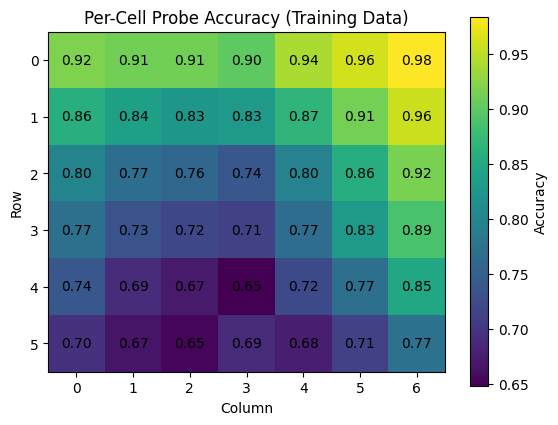

In [59]:
plot_board_heatmap(train_acc, 'Training Data')

In [60]:
val_dataset = torch.utils.data.TensorDataset(val_X, val_Y)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [61]:
val_acc = eval_probe_per_cell(probe, val_loader)
val_acc

tensor([0.9217, 0.9157, 0.9179, 0.9036, 0.9435, 0.9610, 0.9828, 0.8648, 0.8441,
        0.8295, 0.8361, 0.8714, 0.9142, 0.9573, 0.8011, 0.7710, 0.7624, 0.7414,
        0.8011, 0.8593, 0.9166, 0.7778, 0.7428, 0.7202, 0.7168, 0.7689, 0.8337,
        0.8893, 0.7445, 0.7024, 0.6764, 0.6651, 0.7289, 0.7853, 0.8555, 0.6861,
        0.6800, 0.6581, 0.6907, 0.6723, 0.7189, 0.7712], device='cuda:0')

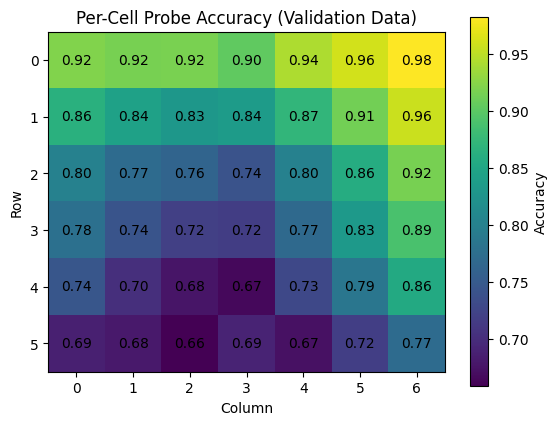

In [62]:
plot_board_heatmap(val_acc, 'Validation Data')